In [9]:
import random
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def generate_seq(sqlen):
    sqlen -= 2
    letters = ['a','b','c','d','E','B']
    spclxy = ['x','y']
    embds = np.eye(8, dtype=np.float32)
    emb_map = {'a':embds[0], 'b':embds[1], 'c':embds[2], 'd':embds[3], 'x':embds[4], 'y':embds[5], 'E':embds[6], 'B':embds[7]}
    class_emb = np.eye(8, dtype=np.float32)
    class_map = {'Q':0, 'R':1, 'S':2, 'U':3, 'V':4, 'A':5, 'B':6, 'C':7}
    conditions = {'xxx':'Q', 'xxy':'R', 'xyx':'S', 'xyy':'U', 'yxx':'V', 'yxy':'A', 'yyx':'B', 'yyy':'C'}
    t1 = random.randint(10,20)
    t2 = random.randint(33,43)
    t3 = random.randint(66,76)
    cursqn = []
    sqnemb = []
    cursqn.append('E')
    xysq = ''
    for i in range(sqlen):
        if i==t1 or i==t2 or i==t3:
            r = random.randint(0,1)
            cursqn.append(spclxy[r])
            xysq += spclxy[r]
        else:
            r = random.randint(0,3)
            cursqn.append(letters[r])
    cursqn.append('B')
    # print(cursqn)
    for i in range(sqlen+2):
        sqnemb.append(emb_map[cursqn[i]])
    sqembmat = np.array(sqnemb)
    # target = np.array(class_emb[class_map[conditions[xysq]]])
    target = np.array(class_map[conditions[xysq]])
    tgt_1hot = [0 for i in range(8)]
    tgt_1hot[target.item()] = 1
    tgt_1hot = np.array(tgt_1hot)
    # print(sqembmat.shape)
    return sqembmat, tgt_1hot

def get_dataset(size, sqlen):
    all_inputs, all_embs = [], []
    for b in range(size):
        inputs, embs = generate_seq(sqlen)
        all_inputs.append(inputs)
        all_embs.append(embs)
    inputs = np.stack(all_inputs)
    label_emb = np.stack(all_embs)
    return inputs, label_emb

def plot_train(losses, seqnum):
    # print(losses.shape)
    seqdone = [i*seqnum for i in range(len(losses))]
    plt.plot(seqdone, losses, label = "Train loss", color='blue')#, markersize=5, marker='o',markerfacecolor='blue')
    plt.xlabel('Number of training sequences')
    plt.ylabel('Loss')
    plt.title('Train loss vs. number of sequences')
    plt.legend()
    plt.show()

## Training LSTM

In [52]:
sqlen = 110#random.randint(100,110)
inputs = keras.Input(shape=(sqlen,8))
mask = keras.layers.Masking(mask_value=0,input_shape=(sqlen, 8))

lstm1 = keras.layers.LSTM(2,return_sequences=True )
lstm2 = keras.layers.LSTM(4,return_sequences=True)
lstm3 = keras.layers.LSTM(8, activation = 'softmax') ### softamx because we want 1hot vector for representing category

out = lstm1(mask(inputs))
out = lstm2(out)
out = lstm3(out)

model = keras.Model(inputs=inputs, outputs=out, name="lstm_q4")
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) 

class myCallback(keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('loss') < 0.1:
			print("Training stopped at Loss =", logs.get('loss'))
			self.model.stop_training = True

my_callback = myCallback()

print(model.summary())

Model: "lstm_q4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 110, 8)]          0         
_________________________________________________________________
masking_6 (Masking)          (None, 110, 8)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 110, 2)            88        
_________________________________________________________________
lstm_19 (LSTM)               (None, 110, 4)            112       
_________________________________________________________________
lstm_20 (LSTM)               (None, 8)                 416       
Total params: 616
Trainable params: 616
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
dsize = 50000
inputs, labels = get_dataset(dsize,sqlen)
# print(inputs.shape, labels.shape)
# print(inputs[0])
# print(labels[0])

Epoch 1/20
137/137 [==============================] - 28s 207ms/step - loss: 1.4938 - accuracy: 0.2692 - val_loss: 1.7978 - val_accuracy: 0.2249
Epoch 2/20
137/137 [==============================] - 28s 206ms/step - loss: 1.6279 - accuracy: 0.2540 - val_loss: 1.3855 - val_accuracy: 0.3341
Epoch 3/20
137/137 [==============================] - 28s 206ms/step - loss: 1.3937 - accuracy: 0.3046 - val_loss: 1.3537 - val_accuracy: 0.3360
Epoch 4/20
137/137 [==============================] - 28s 205ms/step - loss: 1.3100 - accuracy: 0.3785 - val_loss: 1.2360 - val_accuracy: 0.4874
Epoch 5/20
137/137 [==============================] - 28s 206ms/step - loss: 1.1791 - accuracy: 0.5083 - val_loss: 1.0939 - val_accuracy: 0.5359
Epoch 6/20
137/137 [==============================] - 28s 207ms/step - loss: 1.0300 - accuracy: 0.5658 - val_loss: 0.9355 - val_accuracy: 0.5947
Epoch 7/20
137/137 [==============================] - 28s 206ms/step - loss: 0.8822 - accuracy: 0.6200 - val_loss: 0.9934 - val_ac

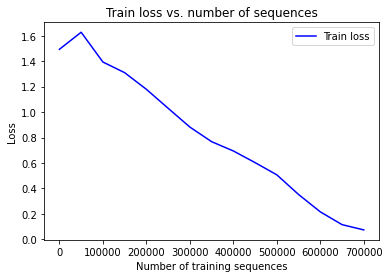

In [57]:
epochs = 20
train_hist = model.fit(inputs, labels, epochs=epochs, batch_size=256, validation_split=0.3 , callbacks=[my_callback])
# print(train_hist.history['loss'])
plot_train(train_hist.history['loss'], dsize)

In [62]:
wrong_preds =0
for trial in range(10):
    w=0
    testinp, testlab = get_dataset(3000,sqlen)
    out = model.predict(testinp)
    for i in range(out.shape[0]):
        pred = np.argmax(out[i])
        org = np.argmax(testlab[i])
        if pred != org:
            w+=1
    print("Trial No:",trial+1,"  ==>  Wrong predictions:",w,"/ 3000")
    wrong_preds+=w
print("Average Missed predictions in LSTM: "+str(wrong_preds/10))

Trial No: 1   ==>  Wrong predictions: 0 / 3000
Trial No: 2   ==>  Wrong predictions: 0 / 3000
Trial No: 3   ==>  Wrong predictions: 2 / 3000
Trial No: 4   ==>  Wrong predictions: 1 / 3000
Trial No: 5   ==>  Wrong predictions: 2 / 3000
Trial No: 6   ==>  Wrong predictions: 1 / 3000
Trial No: 7   ==>  Wrong predictions: 0 / 3000
Trial No: 8   ==>  Wrong predictions: 0 / 3000
Trial No: 9   ==>  Wrong predictions: 1 / 3000
Trial No: 10   ==>  Wrong predictions: 2 / 3000
Average Missed predictions in LSTM: 0.9


## Training RNN

In [68]:

model1 = keras.models.Sequential()
model1.add(keras.Input(shape=(sqlen,8)))
model1.add(keras.layers.SimpleRNN(2, batch_input_shape=(None,sqlen,8),return_sequences=True))
model1.add(keras.layers.SimpleRNN(4, return_sequences=True))
model1.add(keras.layers.SimpleRNN(8, return_sequences=False, activation = 'softmax'))
model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print(model1.summary())

my_callback = myCallback()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 110, 2)            22        
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 110, 4)            28        
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 8)                 104       
Total params: 154
Trainable params: 154
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
137/137 [==============================] - 11s 68ms/step - loss: 0.3798 - accuracy: 0.1251 - val_loss: 0.3776 - val_accuracy: 0.1233
Epoch 2/20
137/137 [==============================] - 9s 65ms/step - loss: 0.3774 - accuracy: 0.1232 - val_loss: 0.3771 - val_accuracy: 0.1247
Epoch 3/20
137/137 [==============================] - 9s 65ms/step - loss: 0.3770 - accuracy: 0.1255 - val_loss: 0.3769 - val_accuracy: 0.1275
Epoch 4/20
137/137 [==============================] - 9s 65ms/step - loss: 0.3769 - accuracy: 0.1263 - val_loss: 0.3768 - val_accuracy: 0.1293
Epoch 5/20
137/137 [==============================] - 9s 66ms/step - loss: 0.3767 - accuracy: 0.1304 - val_loss: 0.3728 - val_accuracy: 0.1919
Epoch 6/20
137/137 [==============================] - 9s 65ms/step - loss: 0.3684 - accuracy: 0.2177 - val_loss: 0.3512 - val_accuracy: 0.2353
Epoch 7/20
137/137 [==============================] - 9s 65ms/step - loss: 0.3451 - accuracy: 0.2416 - val_loss: 0.3237 - val_accuracy: 0.244

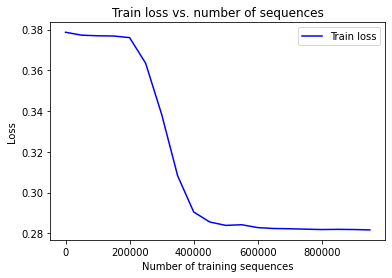

In [69]:

hist = model1.fit(inputs, labels, epochs=20, validation_split=0.3, batch_size=256, callbacks=[my_callback])
plot_train(hist.history['loss'], dsize)

In [70]:
wrong_preds =0
for trial in range(10):
    w=0
    testinp, testlab = get_dataset(3000,sqlen)
    out = model1.predict(testinp)
    for i in range(out.shape[0]):
        pred = np.argmax(out[i])
        org = np.argmax(testlab[i])
        if pred != org:
            w+=1
    print("Trial No:",trial+1,"  ==>  Wrong predictions:",w,"/ 3000")
    wrong_preds+=w
print("Average Missed predictions in RNN: "+str(wrong_preds/10))

Trial No: 1   ==>  Wrong predictions: 2226 / 3000
Trial No: 2   ==>  Wrong predictions: 2255 / 3000
Trial No: 3   ==>  Wrong predictions: 2292 / 3000
Trial No: 4   ==>  Wrong predictions: 2196 / 3000
Trial No: 5   ==>  Wrong predictions: 2261 / 3000
Trial No: 6   ==>  Wrong predictions: 2255 / 3000
Trial No: 7   ==>  Wrong predictions: 2267 / 3000
Trial No: 8   ==>  Wrong predictions: 2239 / 3000
Trial No: 9   ==>  Wrong predictions: 2295 / 3000
Trial No: 10   ==>  Wrong predictions: 2298 / 3000
Average Missed predictions in RNN: 2258.4


As we can see RNN performs much worse on unseen data and is not able to learn the temporal ordder in such long sequence. Whereas LSTM learns and performs much better with very less errors on unseen data in all trials